In [4]:
from napari.experimental._generative_zarr import MandelbulbStore, tile_bounds, mandelbulb

In [125]:
class YTStore(MandelbulbStore):
    def __init__(
        self, yt_file, yt_field, levels, tilesize, 
        maxiter=255, compressor=None, use_yt_load_sample=False,
        take_log=True,
    ):
        if use_yt_load_sample:
            self.ds = yt.load_sample(yt_file)
        else:
            self.ds = yt.load(yt_file)
        
        self.ds.index  # make sure the index is built on initialization            
        self.field = yt_field 
        self.max_coord = 1.0
        self.min_coord = 0.0
        self.take_log = take_log
        
        super().__init__(levels, tilesize, maxiter=maxiter, compressor=compressor, order=4)
        
            
    def get_chunk(self, level, z, y, x):
        # z, y, x are tile centers        
        bounds = tile_bounds(level, (x, y, z), 
                             self.levels,                              
                             min_coord=self.min_coord,
                             max_coord=self.max_coord, )  
        
        tile = self._fetch_data(bounds)  # this is where the mandelbulb call was        
        
        tile = tile.reshape(
            self.tilesize, self.tilesize, self.tilesize
        ).transpose()

        if self.compressor:
            return self.compressor.encode(tile)

        return tile

    def _fetch_data(self, bounds):        
        LE = self.ds.arr(bounds[:,0], "code_length")
        RE = self.ds.arr(bounds[:,1], "code_length")
        frb = self.ds.r[LE[0] : RE[0] : complex(0, self.tilesize),
                        LE[1] : RE[1] : complex(0, self.tilesize),
                        LE[2] : RE[2] : complex(0, self.tilesize)
        ]
        data = frb[self.field]
        if self.take_log: 
            data = np.log10(data)
        return data
        

In [194]:
yt_store = YTStore("IsolatedGalaxy", ("enzo", "Density"), 6, 32, use_yt_load_sample=True, take_log=False)

yt : [INFO     ] 2023-07-18 11:44:24,215 Sample dataset found in '/home/chavlin/hdd/data/yt_data/yt_sample_sets/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2023-07-18 11:44:24,279 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2023-07-18 11:44:24,280 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-07-18 11:44:24,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-18 11:44:24,282 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-18 11:44:24,282 Parameters: cosmological_simulation   = 0
Parsing Hierarchy : 100%|██████████████████| 173/173 [00:00<00:00, 18783.71it/s]
yt : [INFO     ] 2023-07-18 11:44:24,300 Gathering a field list (this may take a moment.)


In [195]:
current_level = yt_store.levels
f = yt_store.get_chunk(current_level, 0, 0, 0)

[0. 0. 0.] code_length
[1. 1. 1.] code_length


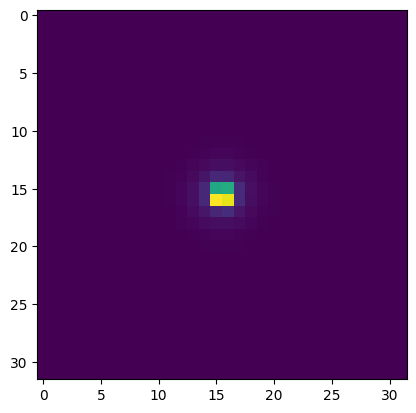

In [196]:
plt.imshow(f[:,:,16])

In [204]:
current_level = 0
x_i, y_i, z_i = 31, 31, 32
f = yt_store.get_chunk(current_level, x_i, y_i, z_i)
print(f.shape)

[0.5      0.484375 0.484375] code_length
[0.515625 0.5      0.5     ] code_length
(32, 32, 32)


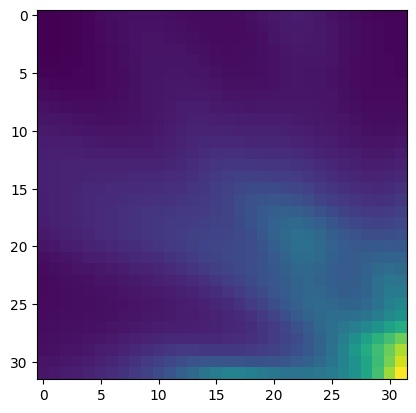

In [205]:
plt.imshow(f[:,:,16])

In [71]:
yt_store.yt_slice

YTSlice (galaxy0030): , axis=2, coord=0.5

In [56]:
tile_bounds_(0, (1, 1, 1), 4, min_coord=0., max_coord=1.0)

array([[0.0625, 0.125 ],
       [0.0625, 0.125 ],
       [0.0625, 0.125 ]])

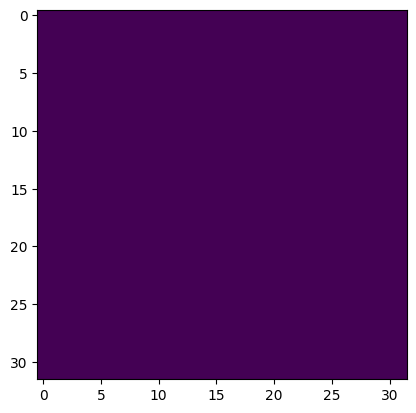

In [36]:
import matplotlib.pyplot as plt 
plt.imshow(d[:,:,16])